In [1]:
import platform

In [3]:
platform.system()

'Windows'

In [1]:
from ortools.linear_solver import pywraplp
import numpy as np
import mdptoolbox, mdptoolbox.example
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman"
})
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
viridis = mpl.colormaps['viridis'].resampled(3000)

In [38]:
O = 3
L = 20
U = 2
A = U
X = O*L


D = 0.5

#### Probability transition kernel 
### Oracle
P_O = np.array([[0.8,0.2,0],
       [0.3,0.2,0.5],
       [0,0.2,0.8]])
### Complete Probability Transition Kernel
P = np.zeros((A, O*L, O*L))
### Probability of Failure for different states and action pairs
fs = np.array([[0,0.3],[0,0.5],[0,0.95]])

### 
for a in range(A):
  for o in range(O):
    f = fs[o,a]
    delta = 0.25 # Arrival rate 
    P_L = (1-delta)*(f)*np.roll(np.identity(L),-1,axis=1) +  ((delta)*(f)+(1-delta)*(1-f))*np.roll(np.identity(L),0,axis=1) + delta*(1-f)*np.roll(np.identity(L),1,axis=1)# Probability transition for learner state
    P_L[0,-1] = 0
    P_L[-1,0] = 0
    # Check for learner state
    if ((P_L>0).sum(axis = 1)>3).sum()>0:
      print("more learner transitions than required")
    P_L = P_L/P_L.sum(axis=1).reshape(L,1) # normalization

    P[a,L*o:(L)*(o+1),:] = np.tile(P_L,(1,O))*np.repeat(P_O[o,:],L,axis=0) # setting the learner transition matrix for o row and a action
    # Check for learner state combined with oracle transition
    if ((P[a,L*o:(L)*(o+1),:]>0).sum(axis =1 )>O*3).sum()>0:
      print("more learner transitions than required")

  P[:,L-1::L,0::L] = 0 # setting the transition from L-1 to 0 to 0 
  P[a,:,:] = P[a,:,:]/P[a,:,:].sum(axis = 1).reshape(O*L,1) ## Normalization 
  P[a,:,:] = np.around(P[a,:,:],7) # Rounding

### Dimension Check
if fs.shape != (O,A):
  print("please correct dimension of fs")
if P_O.shape != (O,O):
  print("please correct dimension of P_O")
### Stochastic Check 
if (np.around(P.sum(axis = 2),5) != 1).sum() > 0:
  print("P is not stochastic")

#### Cost
## Advesarial cost
C_A = [[0,1.6],
     [0,0.7],
     [0,0.2]]
C_A = np.tile(C_A,L).reshape(O*L,A) # tiling adversarial cost 
## Learner Cost
C_L =  np.tile([1.0,0],O*L).reshape(O*L,A)
#    [0,1.55,1.75,3],
#     [0,1.75,2.25,3],
#     [0,2,3,3.25]
# ]
C_L[0::L,:] = [0.5,0]



In [39]:
def solvelp(C_A,C_L,P,X,U,D):
    solver = pywraplp.Solver.CreateSolver('GLOP')
    infinity = solver.infinity()

    pi = {}
    for i in range(X):
        for u in range(U): 
            pi[i,u] =  solver.NumVar(0,infinity, 'pi[%i][%i]'%(i,u))


    constraint = solver.RowConstraint(0, D, '')
    for i in range(X): 
        for u in range(U): 
            constraint.SetCoefficient(pi[i,u],C_L[i][u])
    objective = solver.Objective()

    for i in range(X): 
        for u in range(U):  
            objective.SetCoefficient(pi[i,u], C_A[i][u])

    prob_constraint = [pi[i,u] for i in range(X) for u in range(U)]
    solver.Add(sum(prob_constraint) == 1)
    for j in range(X):
        transition_constraint_left = [pi[j,u] for u in range(U)]
        transition_constraint_right = [P[u][i][j]*pi[i,u] for i in range(X) for u in range(U)]
        solver.Add(sum(transition_constraint_left) == sum(transition_constraint_right))

    objective.SetMinimization()

    status = solver.Solve()
    probpolicy = np.zeros((X,U))
    if status == pywraplp.Solver.OPTIMAL:
        #print('Objective value =', solver.Objective().Value())
        for i in range(X):
            for u in range(U):
                probpolicy[i,u] =  pi[i,u].solution_value()
               #print(pi[i,u].name(), ' = ', pi[i,u].solution_value())
        #print()
        #print('Problem solved in %f milliseconds' % solver.wall_time())
        #print('Problem solved in %d iterations' % solver.iterations())
        #print('Problem solved in %d branch-and-bound nodes' % solver.nodes())
    else:
        print('The problem does not have an optimal solution.')
    return probpolicy

In [40]:
def policyfrom(probpolicy,X):
    policy = (probpolicy/probpolicy.sum(axis = 1).reshape(X,1))[:,0]
    return policy

In [41]:
def expected(P,C,X,policy,T=10000,A = 2,X_0 = 0):
    state = X_0
    totalcost = 0
    for t in range(T):
        action = np.random.choice([0,1],p=[policy[state],1- policy[state]])
        totalcost += C[state][action]
        state = np.random.choice(np.arange(X),p = P[action][state])
    return totalcost/T

In [47]:
def expectedlength(P,X,policy,L,T=10000,A = 2,X_0 = 0):
    state = X_0
    totalcost = 0
    for t in range(T):
        action = np.random.choice([0,1],p=[policy[state],1- policy[state]])
        totalcost += state%(L)
        #int(state%L)
        state = np.random.choice(np.arange(X),p = P[action][state])
    return totalcost/T

In [48]:
probpolicy = solvelp(C_A,C_L,P,X,U,D)
policy = policyfrom(probpolicy,X)
expectedlength(P,X,policy,L,X_0=20,T=100000)

2.30559

In [95]:
# probpolicy = (probpolicy/probpolicy.sum(axis=0).reshape(1,2))[:,:]

# probpolicy.sum(axis=0).reshape(1,2)

In [103]:

Ds = np.linspace(0,0.8,100)
C = np.tile(np.array([0,1]),X).reshape(X,A)
expectedadvcost = np.zeros(100)
for i in range(100):
    D = Ds[i]
    probpolicy = solvelp(C_A,C_L,P,X,U,D)
    policy = policyfrom(probpolicy,X)
    expectedadvcost[i] = expected(P,C,X,policy,T=100000)
    #print(D,expectedadvcost[i])
    if i%10==0:
        print(D,expectedadvcost[i])

0.0 1.0
0.0808080808080808 0.91373
0.1616161616161616 0.83992
0.24242424242424243 0.75845
0.3232323232323232 0.67689
0.40404040404040403 0.58585
0.48484848484848486 0.51106
0.5656565656565656 0.44424
0.6464646464646464 0.35424
0.7272727272727273 0.27166


IndexError: index 100 is out of bounds for axis 0 with size 100

In [143]:
with open('fig1.npy', 'wb') as f:
    np.save(f, Ds)
    np.save(f, expectedadvcost)

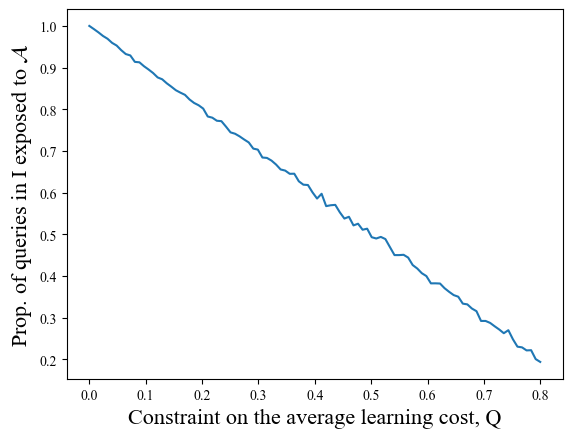

In [149]:
plt.plot(Ds,expectedadvcost)
plt.xlabel("Constraint on the average learning cost, Q",size=16)
plt.ylabel("Prop. of queries in I exposed to $\mathcal{A}$",size=16)
plt.savefig("fig1.eps")
plt.show()


In [6]:
def averagecost_randompolicy(cost,n_iter,P,policy,X_0 = 0):
  X = X_0
  A = P.shape[0]
  O = P.shape[2]
  averagecost = np.zeros(n_iter)
  
  for i in range(n_iter):
    u = policy[X]
    q_k = u[0]
    a_i = int(np.random.choice([0,1],p=[1-q_k,q_k]))
    averagecost[i] = cost[X][a_i]
    X = np.random.choice(np.arange(O),p = P[a_i,X])
  return averagecost.mean()

In [7]:
def sigmoid(x,thres=0,scale=1,tau=1):
    return scale/(1 + np.exp(-(x-thres)/tau))

In [8]:
def policy_from_sigmoid2d(parameters,L,O,A,tau):
    policy = np.zeros((O*L,1),dtype = float)
    n_thresholds = int(parameters.shape[0]-1)//O
    assert n_thresholds==2
    q = np.sin(parameters[-1])**2
    a=0
    for o in range(O):        
        paras = parameters[o*n_thresholds:(o+1)*n_thresholds]
        thresholds = np.array(paras).reshape(n_thresholds)
        for l in range(L):
            policyvalue = sigmoid(l,thresholds[0],q,tau) + sigmoid(l,thresholds[1],1-q,tau) 
            policy[o*L+l] = policyvalue
    return policy

In [9]:
# SPSA algorithm 
def spsa(initial_parameters,delta,n_iter,T,P,D,lamb,epsilon,rho,L,O,A,C_A,C_L,tau=0.3):
  m = initial_parameters.shape[0]
  
  parameters = initial_parameters.copy().reshape(m)
  #policies = np.zeros((n_iter,L*O,2))
  parameters_store = np.zeros((n_iter,m))
  for i in range(n_iter):
    np.random.seed(i)
    pertub = np.random.binomial(1,0.5,(m))
    parameters_plus = parameters + pertub*delta[i]
    parameters_minus = parameters - pertub*delta[i]
    assert parameters_plus.shape == parameters.shape
    policy = policy_from_sigmoid2d(parameters,L,O,A,tau)
    policy_plus = policy_from_sigmoid2d(parameters_plus,L,O,A,tau)
    policy_minus = policy_from_sigmoid2d(parameters_minus,L,O,A,tau)
    C_A_plus = averagecost_randompolicy(C_A,T,P,policy_plus)
    C_A_minus = averagecost_randompolicy(C_A,T,P,policy_minus)
    C_L_plus = averagecost_randompolicy(C_L,T,P,policy_plus)
    C_L_minus = averagecost_randompolicy(C_L,T,P,policy_minus)
    C_L_avg = averagecost_randompolicy(C_L,T,P,policy)
    C_A_avg = averagecost_randompolicy(C_A,T,P,policy)
   # print(C_L_plus,C_L_minus)
    del_C_A = np.zeros(pertub.shape[0])
    del_C_L = np.zeros(pertub.shape[0])

    for j in range(pertub.shape[0]):
      if pertub[j]!=0:
        del_C_A[j] = (C_A_plus - C_A_minus)/(pertub[j]*delta[i])
        del_C_L[j] = (C_L_plus - C_L_minus)/(pertub[j]*delta[i])
       # print(del_C_A[j],del_C_L[j],parameters[j])
    assert del_C_A.shape == parameters.shape
    #print(epsilon*del_C_A)
    parameters = parameters - epsilon[i]*(del_C_A + del_C_L*np.max([0, rho*(C_L_avg-D) ]))
    lamb = np.max([(1-epsilon[i]/rho)*lamb, lamb + epsilon[i]*(C_L_avg - D)])
    #print(parameters,C_A_avg,C_L_avg,lamb,C_L_avg-D)
    if i%100==0:
        print(i,C_A_avg)
    #policies[i] = policy
    parameters_store[i] = parameters
    tau = 0.999*tau
  print(C_A_avg,C_L_avg-D,lamb,parameters)
  return parameters_store


In [23]:
delt

array([0.5, 0.5, 0.5, ..., 0. , 0. , 0. ])

In [49]:
D = 0.6
parameters_initial = np.append(np.tile([7,12],O),np.pi/2)
n_iter = 6000
#delt = np.append(np.repeat(np.pi/2,O*(A)),np.pi/4) #np.power(0.99,(np.arange(1,n_iter+1)))+0.001
delt = np.linspace(0.5,0.4,n_iter)
T = 1000
lamb = 1
epsilon = np.linspace(0.4,0,n_iter)
rho = 2
parameters_spsa = spsa(parameters_initial,delt,n_iter,T,P,D,lamb,epsilon,rho,L,O,A,C_A,C_L)

0 0.3555
100 0.22940000000000002
200 0.195
300 0.0673
400 0.1337
500 0.0952
600 0.116
700 0.1321
800 0.08410000000000001
900 0.07660000000000002
1000 0.0952
1100 0.09140000000000001
1200 0.095
1300 0.0577
1400 0.0866
1500 0.09509999999999999
1600 0.09160000000000001
1700 0.0668
1800 0.058
1900 0.0801
2000 0.09620000000000001
2100 0.07
2200 0.0852
2300 0.054200000000000005
2400 0.061399999999999996
2500 0.0611
2600 0.06160000000000001
2700 0.0534


C:\Users\Adit\AppData\Local\Temp\ipykernel_5564\352852948.py:2: RuntimeWarning: overflow encountered in exp
  return scale/(1 + np.exp(-(x-thres)/tau))


2800 0.07560000000000001
2900 0.05190000000000001
3000 0.0613
3100 0.09230000000000001
3200 0.054299999999999994
3300 0.0573
3400 0.0615
3500 0.0609
3600 0.0886
3700 0.066
3800 0.0638
3900 0.0743
4000 0.0619
4100 0.055200000000000006
4200 0.08470000000000001
4300 0.0654
4400 0.0476
4500 0.061900000000000004
4600 0.060500000000000005
4700 0.055099999999999996
4800 0.057699999999999994
4900 0.0711
5000 0.059300000000000005
5100 0.0522
5200 0.0529
5300 0.046799999999999994
5400 0.0538
5500 0.07130000000000002
5600 0.0561
5700 0.09930000000000001
5800 0.058800000000000005
5900 0.05790000000000001
0.057199999999999994 0.11750000000000005 142.28328048008035 [12.48 12.57  8.1  12.85  1.59 11.72  1.59]


In [39]:
averagecost_randompolicy(C_A,100000,P,policy_from_sigmoid2d(parameters_spsa[-1],L,O,A,tau=0.1))

0.152618

In [37]:
probpolicy = solvelp(C_A,C_L,P,X,U,D)
policy = policyfrom(probpolicy,X)
expected(P,C_A,X,policy,T=10000)
    

0.1496999999999892

In [10]:
parameters_spsa = np.load("parameters_spsa.npy")

In [30]:
np.save("parameters_spsa",parameters_spsa)

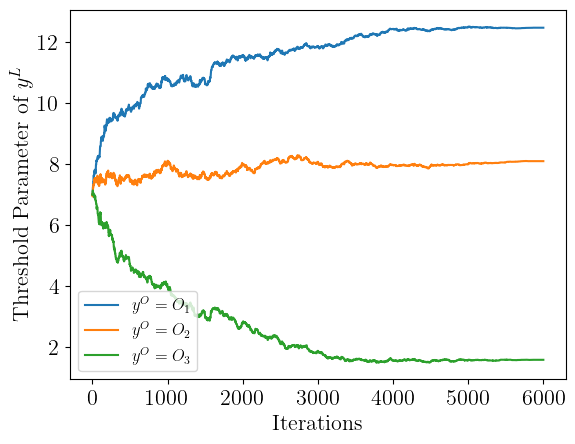

In [50]:
n_iter_sample = 6000
plt.plot(np.arange(n_iter_sample),parameters_spsa[:n_iter_sample,0],label="$y^O = O_1$")
# plt.plot(np.arange(n_iter),parameters_spsa[:,])
plt.plot(np.arange(n_iter_sample),parameters_spsa[:n_iter_sample,2],label="$y^O = O_2$")
plt.plot(np.arange(n_iter_sample),parameters_spsa[:n_iter_sample,4],label="$y^O = O_3$")
# plt.plot(np.arange(n_iter_sample),parameters_spsa[:n_iter_sample,1],'..',label="$y^O = O_1$")
# # plt.plot(np.arange(n_iter),parameters_spsa[:,])
# plt.plot(np.arange(n_iter_sample),parameters_spsa[:n_iter_sample,3],'..',label="$y^O = O_2$")
# plt.plot(np.arange(n_iter_sample),parameters_spsa[:n_iter_sample,5],'..',label="$y^O = O_3$")
plt.legend(fontsize=12)
plt.legend(fontsize=12)
plt.xlabel("Iterations",size = 16)
plt.ylabel("Threshold Parameter of $y^L$", size = 16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig("fig2.pdf",bbox_inches='tight',pad_inches=0)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


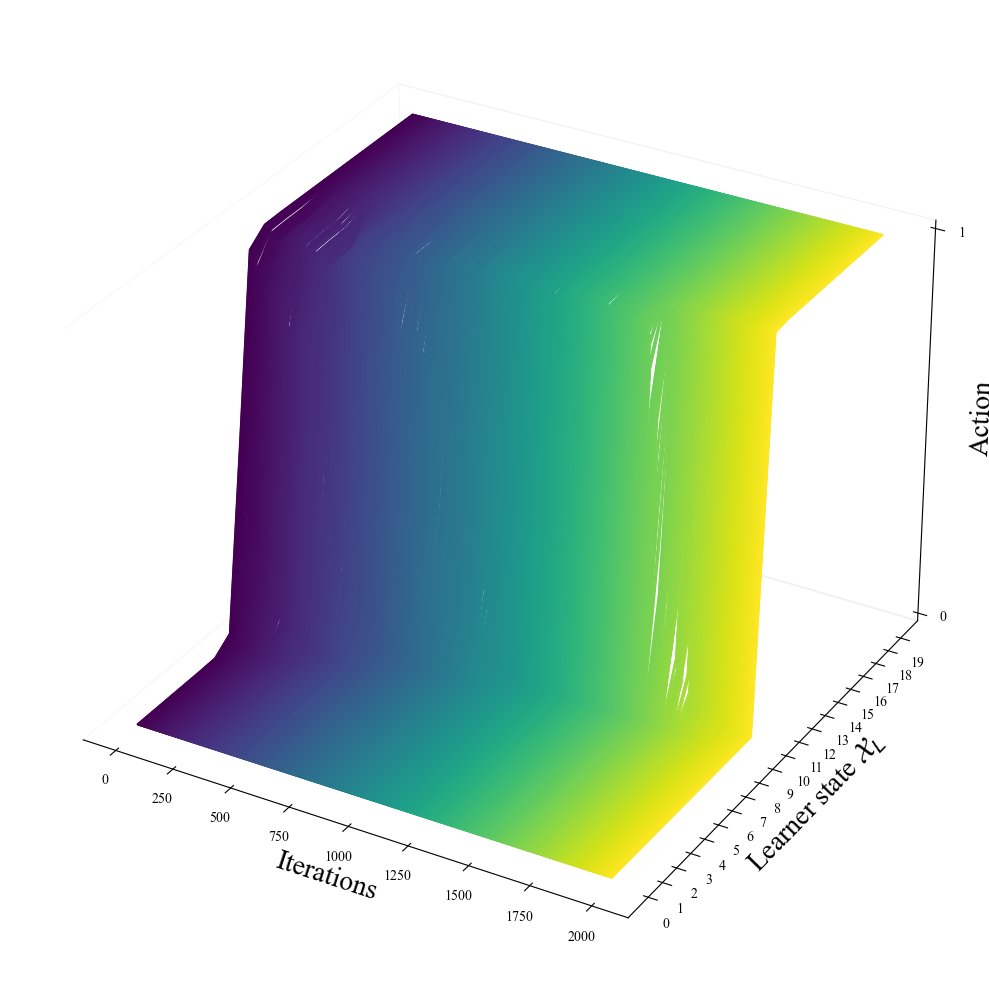

In [217]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
for i in range(2000):
    ax.plot(np.arange(L),policies_spsa[i][:L,0],i,zdir='x',c = viridis(i/2000))
ax.set_xlabel("Iterations",size=20)
ax.set_ylabel("Learner state $\mathcal{X}_L$",size=20)
ax.set_zlabel("Action", size=20) 
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_yticks(np.arange(L))
ax.set_zticks([0,1])
#ax.zaxis.labelpad=-2 # <- change the value here
plt.savefig("fig2.eps")
plt.show()


In [10]:
import mdptoolbox

In [121]:
def oracle(x,p_success,sigma):
    p_error = 1 - p_success
    if np.random.choice([0,1],p = [p_error,1-p_error]):
        return 2*x + np.random.normal(0,sigma)
    else:
        return 0

In [253]:
for i in range(N+1):

IndentationError: expected an indented block (1780955870.py, line 1)

In [259]:
def process(N,M,policies,fs,P_O,O,sigma,x_learner=5,learnerinterval=[-1,1]):
    j=1
    learner_state = M-1
    oracle_state = 0
    n_adv = 0
    ad_estimates = np.zeros(N+1)
    ad_estimates_1 = np.zeros(N+1)
    learner_estimates = np.zeros(N+1)
    learner_estimates[0] = x_learner
    ad_estimates[0] = (1)*x_learner + (0)*20
    ad_estimates_1[0]  = [20,x_learner][np.argmax([0,0])]
    advqueries = np.zeros(N+1)
    for i in range(1,N+1):
        
        policy = policies[i-1]
        action = policy[oracle_state*M + learner_state]            
        p_success = fs[oracle_state][action]
        
        grad = oracle(x_learner,p_success,sigma)
        if action ==1:
            if grad !=0:
                if x_learner - grad/j>=learnerinterval[0] and x_learner - grad/j<=learnerinterval[1]:
                    x_learner = x_learner - grad/j
                elif x_learner - grad/j<learnerinterval[0]:
                    x_learner = learnerinterval[0]
                else:
                    x_learner = learnerinterval[1]
                j+=1
                learner_state-=1
        else: 
            n_adv+=1
        advqueries[i] = n_adv
        learner_estimates[i] = x_learner
        ad_estimates[i] = (1 - (n_adv/i))*x_learner + (n_adv/i)*20
        ad_estimates_1[i]  = [20,x_learner][np.argmax([n_adv,i - n_adv])]
        oracle_state = np.random.choice(np.arange(O),p = P_O[oracle_state])
    return learner_estimates,ad_estimates,ad_estimates_1,advqueries

In [266]:
A = 2
L = 10
P_O = np.array([[0.85,0.15,0],
       [0.15,0.7,0.15],
       [0,0.15,0.85]])
### Complete Probability Transition Kernel
P = np.zeros((A, O*L, O*L))
### Probability of Failure for different states and action pairs
fs = np.array([[0,0.3],[0,0.5],[0,0.95]])

### 
for a in range(A):
  for o in range(O):
    f = fs[o,a]
    delta = 0 # Arrival rate 
    P_L = (1-delta)*(f)*np.roll(np.identity(L),-1,axis=1) +  ((delta)*(f)+(1-delta)*(1-f))*np.roll(np.identity(L),0,axis=1) + delta*(1-f)*np.roll(np.identity(L),1,axis=1)# Probability transition for learner state
    P_L[0,-1] = 0
    P_L[-1,0] = 0
    # Check for learner state
    if ((P_L>0).sum(axis = 1)>3).sum()>0:
      print("more learner transitions than required")
    P_L = P_L/P_L.sum(axis=1).reshape(L,1) # normalization

    P[a,L*o:(L)*(o+1),:] = np.tile(P_L,(1,O))*np.repeat(P_O[o,:],L,axis=0) # setting the learner transition matrix for o row and a action
    # Check for learner state combined with oracle transition
    if ((P[a,L*o:(L)*(o+1),:]>0).sum(axis =1 )>O*3).sum()>0:
      print("more learner transitions than required")

  P[:,L-1::L,0::L] = 0 # setting the transition from L-1 to 0 to 0 
  P[a,:,:] = P[a,:,:]/P[a,:,:].sum(axis = 1).reshape(O*L,1) ## Normalization 
  P[a,:,:] = np.around(P[a,:,:],7) # Rounding

C_A = [[2,1,0],
     [1,0.5,0]]
C =np.repeat(C_A,L,axis=1).T

H = np.tile(np.linspace(10,0,L),O)

In [282]:
N = 30
fh = mdptoolbox.mdp.FiniteHorizon(P,C,1,N,H)
#fh.setVerbose()
fh.run()
#fh.policy[:,14]

In [283]:
policy = fh.policy.T

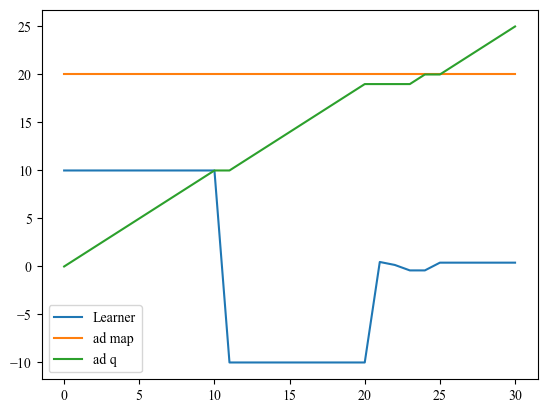

In [285]:
learner_estimates,ad_estimates,ad_estimates_1,advqueries = process(N,L,policy,fs,P_O,O,2,10,[-10,10])

plt.plot(np.arange(N+1),learner_estimates,label="Learner")
#plt.plot(np.arange(N+1),ad_estimates,label="ad avg")
plt.plot(np.arange(N+1),ad_estimates_1,label="ad map")
plt.plot(np.arange(N+1),advqueries,label="ad q")

plt.legend()